In [45]:
path = 'data/statefarm/'
#path = 'data/statefarm/sample/'

## Setup for splitting data

In [29]:
import glob
import os
import numpy as np
import zipfile

download_path = "data/statefarm/"
image_zip = download_path+'imgs.zip'

validation_percent = 0.15
num_sample_files = 10

# These will be created by unzipping
train_dir = download_path + 'train/'
test_dir = download_path + 'test/'

# keras requires a direc to read images. create dummy for test files.
test_unknown_dir = test_dir + 'unknown/'

# Following are for validation and "small sample testing" 
val_dir = download_path + 'valid/'
sample_dir = download_path + 'sample/'
sample_train_dir = sample_dir + 'train/'
sample_valid_dir = sample_dir + 'valid/'
sample_test_dir = sample_dir + 'test/'
sample_test_unknown_dir = sample_test_dir + 'unknown/'

directories_to_create = [val_dir, sample_dir, sample_train_dir, sample_valid_dir, sample_test_dir, sample_test_unknown_dir]

#Following new files will be created after splitting
#for cx in [c0,c1,c2.....cn]
#data/statefarm/valid/cx/   (15% random images from train/cx/ are moved here)
#data/statefarm/sample/train/cx/ (10 random images from ../train/cx are *copied* here)
#data/statefarm/sample/valid/cx/  (10 random images from ../valid/cx are *copied* here)
#data/statefarm/sample/test/   (10 random images from ../test are *copied* here)


## Start from unzipping the downloaded file

In [30]:
# Input =  kaggle image zip file 'imgs.zip'
# Everytime this cell is run, we start fresh from unzipping. 
# First remove train and test if they exist.
os.system('rm -f -r ' + train_dir)
os.system('rm -f -r ' + test_dir)

# Extract images from zip file
with zipfile.ZipFile(image_zip, "r") as zip_ref:
    zip_ref.extractall(download_path)

# Read class labels
training_class_paths = glob.glob(train_dir + '*')
class_labels = [x.split('/')[-1] for x in training_class_paths]

## Create/Clean directories

In [31]:
def clean_directory(directory):
    if not os.path.exists(directory):
        os.system('mkdir {}'.format(directory))
    else:
        os.system('rm -rf {}*'.format(directory))

# Create directories from top level to bottom
for directory in directories_to_create:
    clean_directory(directory)

# Create a directory for each class label in valid/ , sample/train/ sample/valid
for label in class_labels:
    valid_cx = val_dir + label + '/'
    sample_train_cx = sample_train_dir + label + '/'
    sample_valid_cx = sample_valid_dir + label + '/'
    
    clean_directory(valid_cx)
    clean_directory(sample_train_cx)
    clean_directory(sample_valid_cx)

### Move test files to under 'unknown' directory

In [34]:
# There are 80K test files. Too slow to move one at a time. 
# first move test/ to unknown/ 
# then create test/
# move unknown into test/
temp_unknown = [x + '/' for x in test_dir.split('/')[0:-2]]

temp_unknown = ''.join(temp_unknown)+'unknown'

os.system('mv {} {}'.format(test_dir, temp_unkown))
os.system('mkdir {}'.format(test_dir))
os.system('mv {} {}'.format(temp_unkown, test_dir))

0

## Utilities for moving files

In [ ]:
def create_class_x_valid_from_training(training_class_path):
    training_class_files = glob.glob(training_class_path+'/*')
    
    num_training_files = len(training_class_files)
    num_valid_files = np.floor(validation_percent*num_training_files)
    
    files_idxs_to_move = np.random.randint(0, num_training_files, num_valid_files)
    
    for training_idx in files_idxs_to_move:
        training_file = training_class_files[training_idx]
        valid_file = training_file.replace('train','valid')
        os.system('mv -f ' + training_file + ' ' + valid_file)

def create_class_x_sample(class_path, sub_type):
    class_files = glob.glob(class_path+'/*')
    num_files = len(class_files)
    files_idxs_to_move = np.random.randint(0, num_files, num_sample_files)

    for idx in files_idxs_to_move:
        source_file = class_files[idx]
        dest_file = source_file.replace(sub_type, 'sample/' + sub_type)
        os.system('cp -f ' + source_file + ' ' + dest_file)

## Move/copy files

In [36]:
for training_class_path in training_class_paths:
    
    valid_class_path = training_class_path.replace('train','valid')
    
    create_class_x_valid_from_training(training_class_path)
    
    # for this class, move from train/cx to sample/train/cx .
    # from valid/cx to sample/valid/cx.
    create_class_x_sample(training_class_path, 'train')
    create_class_x_sample(valid_class_path, 'valid')

# Move some images to sample/test
create_class_x_sample(test_unknown_dir, 'test')

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Done restructuring the data. 

In [65]:
path = "data/statefarm/"
#path = "data/statefarm/sample/"

A few basic libraries that we'll need for the initial exercises:

In [66]:
%matplotlib inline
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [67]:
import utils; reload(utils)
from utils import plots

# Use a pretrained VGG model with our **Vgg16** class

In [4]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64

# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16
vgg = Vgg16()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [5]:
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=4)

Found 19307 images belonging to 10 classes.
Found 3117 images belonging to 10 classes.
Epoch 1/4
19307/19307 [==============================] - 532s - loss: 10.0898 - acc: 0.3317 - val_loss: 6.3941 - val_acc: 0.5698
Epoch 2/4
19307/19307 [==============================] - 530s - loss: 5.5506 - acc: 0.5989 - val_loss: 2.5945 - val_acc: 0.7918
Epoch 3/4
19307/19307 [==============================] - 530s - loss: 0.9381 - acc: 0.7878 - val_loss: 0.1306 - val_acc: 0.9666
Epoch 4/4
19307/19307 [==============================] - 530s - loss: 0.4349 - acc: 0.8683 - val_loss: 0.0898 - val_acc: 0.9791


In [6]:
#vgg.model.save_weights(path+'my_vgg_weights_2.h5')

In [8]:
#vgg.model.load_weights(path+'my_vgg_weights_2.h5')

## Visualize some test images and their predictions

In [ ]:
test_batches = vgg.get_batches(path+'test', batch_size=4)

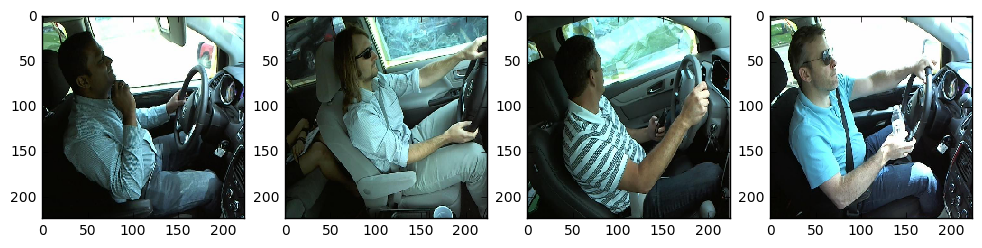

In [20]:
test_imgs, labels = next(test_batches) #ignore labels for test data. 
plots(test_imgs)

In [21]:
vgg.predict(test_imgs)

(array([ 0.7526,  0.7946,  0.7478,  0.8103], dtype=float32),
 array([8, 0, 0, 6]),
 [u'hen', u'tench', u'tench', u'stingray'])

In [11]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

# Use a different finetuning: instead of training a smaller dense layer, retrain the bigger 4k dense layer in vgg with our data

In [68]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64

# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16
vgg = Vgg16()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_8 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [ ]:
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune_1(batches)
vgg.fit(batches, val_batches, nb_epoch=4)

Found 19307 images belonging to 10 classes.
Found 3117 images belonging to 10 classes.
Epoch 1/4
  192/19307 [..............................] - ETA: 570s - loss: 8.8868 - acc: 0.1510

In [48]:
#model tunedd with finetune_1
vgg.model.save_weights(path+'my_vgg_weights_3.h5')

In [31]:
#vgg.model.load_weights(path+'my_vgg_weights_1_e.h5')

## Visualize some test images and their predictions

In [ ]:
test_batches = vgg.get_batches(path+'test', batch_size=4)

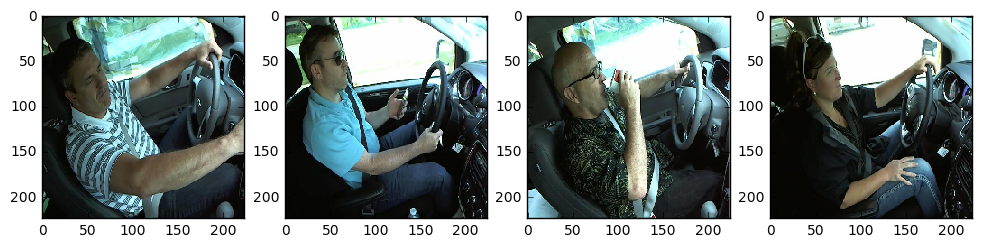

In [62]:
test_imgs, labels = next(test_batches) #ignore labels for test data. 
plots(test_imgs)

In [63]:
vgg.predict(test_imgs)

(array([ 1.,  1.,  1.,  1.], dtype=float32),
 array([9, 6, 6, 6]),
 [u'ostrich', u'stingray', u'stingray', u'stingray'])

In [64]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_7 (Lambda)                (None, 3, 224, 224)   0           lambda_input_7[0][0]             
____________________________________________________________________________________________________
zeropadding2d_79 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_7[0][0]                   
____________________________________________________________________________________________________
convolution2d_79 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_79[0][0]           
____________________________________________________________________________________________________
zeropadding2d_80 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_79[0][0]           
___________________________________________________________________________________________

The category indexes are based on the ordering of categories used in the VGG model - e.g here are the first four:

(Note that, other than creating the Vgg16 object, none of these steps are necessary to build a model; they are just showing how to use the class to view imagenet predictions.)

## Use our Vgg16 class to finetune a Dogs vs Cats model

To change our model so that it outputs "cat" vs "dog", instead of one of 1,000 very specific categories, we need to use a process called "finetuning". Finetuning looks from the outside to be identical to normal machine learning training - we provide a training set with data and labels to learn from, and a validation set to test against. The model learns a set of parameters based on the data provided.

However, the difference is that we start with a model that is already trained to solve a similar problem. The idea is that many of the parameters should be very similar, or the same, between the existing model, and the model we wish to create. Therefore, we only select a subset of parameters to train, and leave the rest untouched. This happens automatically when we call *fit()* after calling *finetune()*.

We create our batches just like before, and making the validation set available as well. A 'batch' (or *mini-batch* as it is commonly known) is simply a subset of the training data - we use a subset at a time when training or predicting, in order to speed up training, and to avoid running out of memory.

In [65]:
batch_size=64

In [66]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 22778 images belonging to 2 classes.
Found 2222 images belonging to 2 classes.


Calling *finetune()* modifies the model such that it will be trained based on the data in the batches provided - in this case, to predict either 'dog' or 'cat'.

In [67]:
vgg.finetune(batches)

Finally, we *fit()* the parameters of the model using the training data, reporting the accuracy on the validation set after every epoch. (An *epoch* is one full pass through the training data.)

In [68]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
22778/22778 [==============================] - 616s - loss: 0.1220 - acc: 0.9677 - val_loss: 0.0809 - val_acc: 0.9815


## After finetuning and trainingand validating using the new dataset, accuracy looks good. Below, first array is probability, second is class, ignore the third since the labels are the original vgg labels corresponding to 0 and 1 indices. 

In [69]:
vgg.predict(imgs,True)

(array([ 0.9997,  1.    ,  1.    ,  1.    ], dtype=float32),
 array([1, 0, 0, 0]),
 [u'goldfish', u'tench', u'tench', u'tench'])

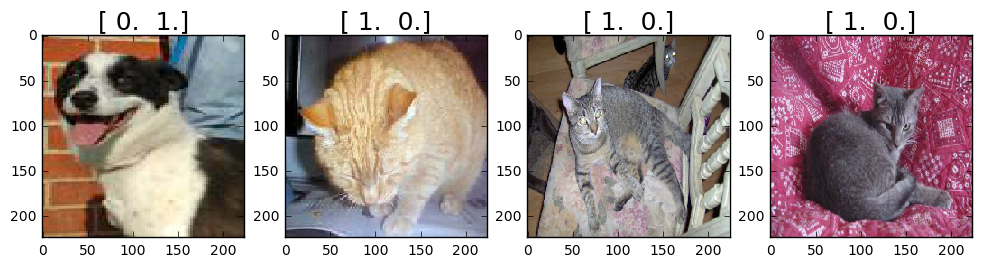

In [70]:
plots(imgs, titles=labels)

That shows all of the steps involved in using the Vgg16 class to create an image recognition model using whatever labels you are interested in. For instance, this process could classify paintings by style, or leaves by type of disease, or satellite photos by type of crop, and so forth.

Next up, we'll dig one level deeper to see what's going on in the Vgg16 class.

## Predict on the test images. 

## First understand how filenames map to the images in test_batch

In [40]:
test_batch_size=100
test_batches = vgg.get_batches(path+'test', batch_size=test_batch_size,shuffle=False)

Found 0 images belonging to 0 classes.


In [193]:
test_batch = next(test_batches)
predictions = vgg.predict(test_batch[0],True)

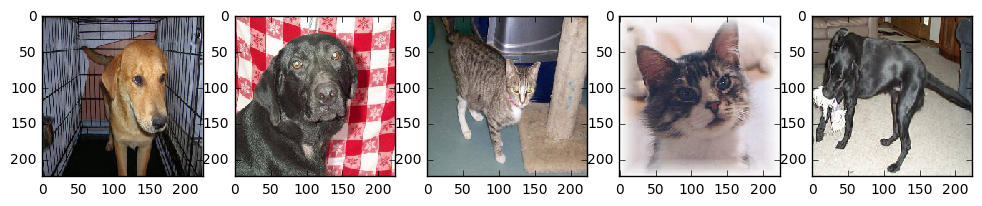

In [197]:
plots(test_batch[0][40:45])

In [170]:
predictions[0][40:45]

array([ 1.    ,  1.    ,  0.9861,  1.    ,  1.    ], dtype=float32)

In [194]:
(predictions[1]==1).sum()

49

In [195]:
(predictions[1]==0).sum()

51

In [196]:
predictions[1][40:45]

array([1, 1, 0, 0, 1])

In [35]:
test_batches.filenames[0:12]

['test_imgs/9292.jpg',
 'test_imgs/12026.jpg',
 'test_imgs/9688.jpg',
 'test_imgs/4392.jpg',
 'test_imgs/779.jpg',
 'test_imgs/2768.jpg',
 'test_imgs/2399.jpg',
 'test_imgs/12225.jpg',
 'test_imgs/10947.jpg',
 'test_imgs/1780.jpg',
 'test_imgs/11631.jpg',
 'test_imgs/8478.jpg']

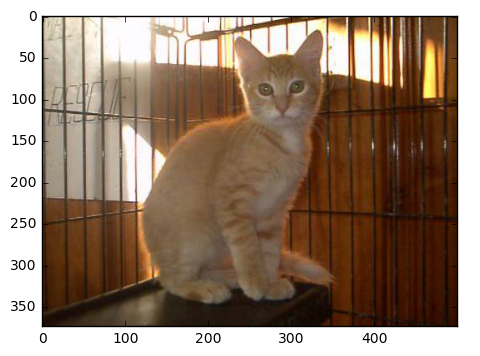

In [33]:
from scipy import misc
vis_check = misc.imread(path+'test/test_imgs/1780.jpg')
plt.imshow(vis_check)

### The above confirms the mapping of filenames to images

In [36]:
test_batch_size=100
num_test_images=12500
test_batches = vgg.get_batches(path+'test', batch_size=test_batch_size,shuffle=False)

Found 12500 images belonging to 1 classes.


In [ ]:
num_images = 0
all_predictions = np.zeros((num_test_images,2))
for test_batch in test_batches:
    predictions = vgg.predict(test_batch[0],True) #test_batch[0] is images. [1] is labels - ignore for test test.
    all_predictions[num_images:(num_images+test_batch_size),0] = predictions[0]
    all_predictions[num_images:(num_images+test_batch_size),1] = predictions[1]
    num_images = num_images + test_batch_size
    if num_images>=num_test_images:
        break

In [43]:
fnames_s = pd.Series(test_batches.filenames)
result_df = pd.DataFrame(fnames_s.str.split('.').str[0].values,columns=['id'])
result_df['id'] = result_df['id'].str.split('/').str[1]

result_df['label'] = all_predictions[:,0:1]
result_df['classes'] = all_predictions[:,1:2]
result_df = result_df.sort_values(by='id')

result_df = result_df.set_index('id')
cat_idx = result_df[result_df.classes==0].index
result_df.loc[cat_idx,'label'] = 1 - result_df.loc[cat_idx,'label']
result_df = result_df.drop(['classes'],axis=1)

In [44]:
result_df['label'] = result_df['label'].clip(lower=0.02, upper=0.98)

In [47]:
result_df.to_csv('data/redux_dogscats/submission_1.csv')

In [252]:
result_df[result_df.probs>=0.5].shape

(6206, 1)

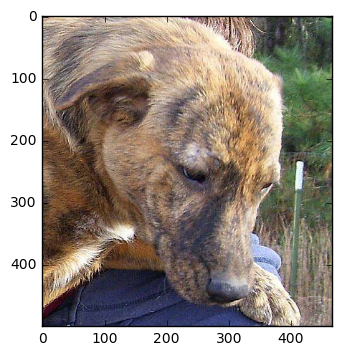

In [254]:
imtest = misc.imread(path+'test/test_imgs/10000.jpg')
plt.imshow(imtest)

# Create a VGG model from scratch in Keras

For the rest of this tutorial, we will not be using the Vgg16 class at all. Instead, we will recreate from scratch the functionality we just used. This is not necessary if all you want to do is use the existing model - but if you want to create your own models, you'll need to understand these details. It will also help you in the future when you debug any problems with your models, since you'll understand what's going on behind the scenes.

## Model setup

We need to import all the modules we'll be using from numpy, scipy, and keras:

In [17]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Let's import the mappings from VGG ids to imagenet category ids and descriptions, for display purposes later.

In [18]:
FILES_PATH = 'http://www.platform.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

Here's a few examples of the categories we just imported:

In [19]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

## Model creation

Creating the model involves creating the model architecture, and then loading the model weights into that architecture. We will start by defining the basic pieces of the VGG architecture.

VGG has just one type of convolutional block, and one type of fully connected ('dense') block. Here's the convolutional block definition:

In [20]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

...and here's the fully-connected definition.

In [21]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

When the VGG model was trained in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Furthermore, their software that expected the channels to be in B,G,R order, whereas Python by default uses R,G,B. We need to preprocess our data to make these two changes, so that it is compatible with the VGG model:

In [22]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

Now we're ready to define the VGG model architecture - look at how simple it is, now that we have the basic blocks defined!

In [23]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding patterns in images
- Dense (fully connected) layers are for combining patterns across an image

Now that we've defined the architecture, we can create the model like any python object:

In [24]:
model = VGG_16()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_3 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


As well as the architecture, we need the weights that the VGG creators trained. The weights are the part of the model that is learnt from the data, whereas the architecture is pre-defined based on the nature of the problem. 

Downloading pre-trained weights is much preferred to training the model ourselves, since otherwise we would have to download the entire Imagenet archive, and train the model for many days! It's very helpful when researchers release their weights, as they did here.

In [25]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

## Getting imagenet predictions

The setup of the imagenet model is now complete, so all we have to do is grab a batch of images and call *predict()* on them.

In [26]:
batch_size = 4

Keras provides functionality to create batches of data from directories containing images; all we have to do is to define the size to resize the images to, what type of labels to create, whether to randomly shuffle the images, and how many images to include in each batch. We use this little wrapper to define some helpful defaults appropriate for imagenet data:

In [27]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

From here we can use exactly the same steps as before to look at predictions from the model.

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


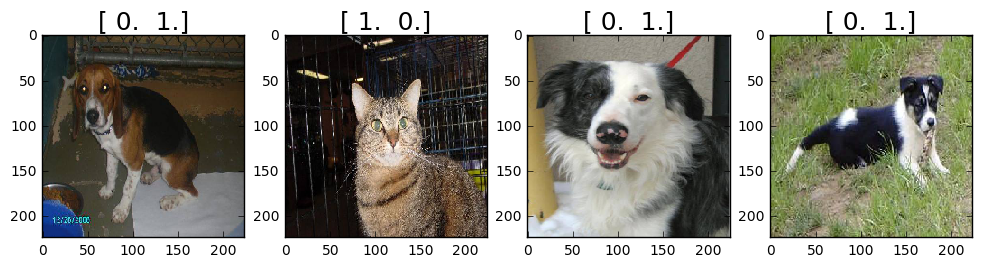

In [28]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

The VGG model returns 1,000 probabilities for each image, representing the probability that the model assigns to each possible imagenet category for each image. By finding the index with the largest probability (with *np.argmax()*) we can find the predicted label.

In [34]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [35]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  1.1169e-08   1.7160e-07   2.2501e-06   2.3426e-08   5.9417e-08]

Predictions prob/class: 
  0.2285/papillon
  0.2947/lynx
  0.6434/Egyptian_cat
  0.4845/Australian_terrier
